# Домашнее задание 3

Выполнил Козин Роман

# Часть 1. Классификатор 128×128

## Датасет

Для ускорения процесса обучения используем не весь датасет ImageNet, возьмём часть классов. Пусть будет 20 классов. Выберем их случайным образом

In [1]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import random
import torch

In [2]:
random.seed(52)
torch.manual_seed(52)
np.random.seed(52)

In [3]:
CLASS_NUM = 20
classes_path = './data/tiny-imagenet-200/tiny-imagenet-200/wnids.txt'
with open(classes_path) as f:
    ids = f.read().split('\n')
selected_classes = random.sample(ids[:-1], CLASS_NUM)
print(selected_classes)

['n01882714', 'n02279972', 'n02699494', 'n02123394', 'n03026506', 'n01910747', 'n04532106', 'n07920052', 'n02058221', 'n07695742', 'n02268443', 'n07753592', 'n03160309', 'n04356056', 'n01784675', 'n02124075', 'n04417672', 'n02927161', 'n04540053', 'n09193705']


На всякий случай зафиксируем

In [4]:
selected_classes = ['n01882714', 'n02279972', 'n02699494', 'n02123394', 'n03026506', 
                    'n01910747', 'n04532106', 'n07920052', 'n02058221', 'n07695742', 
                    'n02268443', 'n07753592', 'n03160309', 'n04356056', 'n01784675', 
                    'n02124075', 'n04417672', 'n02927161', 'n04540053', 'n09193705']

Возьмём ту же реализацию датасета из прошлого ДЗ, останется только добавить resize в изображения. Делать дополнительной стратификации для разделения датасета на обучение и валидацию не нужно, в ImageNet датасет уже разбит на нужные выборки.

In [5]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import torch
import os

class SmallDataset(Dataset):
    def __init__(self, root: str, classes: list[str], ds_type: str, device = torch.device("cpu"), transform = None) -> None:
        super().__init__()
        self.ds_type = ds_type
        self.root = root
        self.classes = classes
        if ds_type == 'val':
            self.prepareValData()
        self.device = device
        self.transform = transform
        self.label_to_idx = {label : idx for idx, label in enumerate(classes)}
        
    def prepareValData(self) -> None:
        self.valData = []
        labelsSet = set(self.classes)
        with open(os.path.join(self.root, self.ds_type, "val_annotations.txt")) as f:
            rows = f.readlines()
            f.close()    
        for row in rows:
            data = self._parseLine(row)
            label = data[1]
            if label in labelsSet:
                self.valData.append(tuple(data))
    
    def _parseLine(self, row: str):
        els = row.split("\t")
        data = [els[k].strip("\n") for k in range(len(els))]
        if self.ds_type == 'val':
            start_idx = 2
        else:
            start_idx = 1
        for i in range(start_idx, len(data)):
            data[i] = int(data[i])
        return data
    
    def __getitem__(self, index: int):
        if self.ds_type == 'val':
            data = self.valData[index]
            img_path = os.path.join(self.root, self.ds_type, "images", data[0])
            label = data[1]
            bbox = tuple(data[2:])
        else:
            label_idx = index // 500
            img_idx = index % 500
            label = self.classes[label_idx]
            label_root = os.path.join(self.root, self.ds_type, label)
            img_path = os.path.join(label_root, "images", f'{label}_{img_idx}.JPEG')
            with open(os.path.join(label_root, f"{label}_boxes.txt")) as f:
                rows = f.readlines()
                f.close()
            row = rows[img_idx]
            data = self._parseLine(row)
            bbox = tuple(data[1:])
        
        bbox = torch.tensor(bbox).to(self.device)
        img = Image.open(img_path).convert('RGB')
            
        if self.transform:
            img = self.transform(img)
        return (img.to(self.device), torch.tensor(self.label_to_idx[label]).to(self.device), bbox)
        
    def __len__(self) -> int:
        #структура исходного датасета такова, что на каждый класс приходится 500 изображений
        if self.ds_type == 'train':
            return len(self.classes) * 500
        else:
            return len(self.valData)

Увеличим размер изображений до 128x128 при помощи ```transforms.Resize()```, используем стандартную билинейную интерполяцию. Также в тренировку добавим несколько аугментаций для более стабильного обучения. Добавим аугментации, предложенные в задании: RandomResizedCrop, Flip, Rotation.

В RandomResizedCrop выставим адекватные размеры обрезки, чтобы не оставлять в датасете слишком маленькие участки исходного изображения.

В RandomRotation используем повороты до 30 градусов, чтобы тоже слишком сильно не искажать изображения.

In [6]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop((128, 128), (0.9, 1)),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #найденные в интернете параметры для imagenet
                        std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #найденные в интернете параметры для imagenet
                        std=[0.229, 0.224, 0.225])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = "./data/tiny-imagenet-200/tiny-imagenet-200"
train_data = SmallDataset(root=data_root, classes=selected_classes,
                          ds_type='train', transform=train_transforms, device=device)
val_data = SmallDataset(root=data_root, classes=selected_classes,
                        ds_type='val', transform=val_transforms, device=device)
train_data_loader = DataLoader(train_data,batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=16, shuffle=True)

In [7]:
img, label, bbox = train_data[0]

print(img.shape)

torch.Size([3, 128, 128])


## Модель

Сперва ради эксперимента попробуем обучить модель из прошлого дз и посмотрим на её точность. Используем тот же код для обучения, также будем использовать AdamW.

In [8]:
from copy import deepcopy

def train_one_run(model, optimizer, criterion, train_data_loader, val_data_loader, save_path, epoch_num=20):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_val_acc = 0.0
    best_state_dict = None
    train_acc = None

    for epoch in range(epoch_num):
        train_correct = 0
        train_predicted = 0
        model.train()
        
        for images, labels, _ in tqdm(desc=f"Training epoch {epoch + 1}", iterable=train_data_loader):
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            preds = logits.argmax(dim=-1)
            train_correct += (preds == labels).sum().item()
            train_predicted += labels.size(0)
        
        train_loss_history.append(loss.item())
        train_acc_history.append(train_correct / train_predicted)

        model.eval()
        val_correct = 0
        val_predicted = 0
        
        with torch.no_grad():
            for images, labels, _ in tqdm(iterable=val_data_loader, desc=f"Validating"):
                logits = model(images)
                loss = criterion(logits, labels)
                preds = logits.argmax(dim=-1)
                val_correct += (preds == labels).sum().item()
                val_predicted += labels.size(0)
            
            val_loss_history.append(loss.item())
            val_acc = val_correct / val_predicted
            val_acc_history.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = deepcopy(model.state_dict())
            train_acc = train_correct / train_predicted
            torch.save(model.state_dict(), save_path)

    return {
        "best_state_dict": best_state_dict,
        "best_val_acc": best_val_acc,
        "best_train_acc" : train_acc,
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "train_acc_history": train_acc_history,
        "val_acc_history": val_acc_history,
    }


def train_multiple_runs(runs, model_constructor, optimizer_constructor, criterion, train_data_loader, val_data_loader, save_path, epoch_num=20):
    all_train_losses = []
    all_val_losses = []
    all_train_accs = []
    all_val_accs = []

    best_overall_train_acc = None
    best_overall_val_acc = 0.0
    best_overall_state_dict = None

    for run in range(runs):
        print(f"\n===== Run {run + 1}/{runs} =====")
        model = model_constructor()
        optimizer = optimizer_constructor(model)

        result = train_one_run(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_data_loader=train_data_loader,
            val_data_loader=val_data_loader,
            epoch_num=epoch_num,
            save_path = save_path
        )

        all_train_losses.append(result["train_loss_history"])
        all_val_losses.append(result["val_loss_history"])
        all_train_accs.append(result["train_acc_history"])
        all_val_accs.append(result["val_acc_history"])

        if result["best_val_acc"] > best_overall_val_acc:
            best_overall_val_acc = result["best_val_acc"]
            best_overall_state_dict = deepcopy(result["best_state_dict"])
            best_overall_train_acc = result["best_train_acc"]

    mean_train_losses = np.mean(np.array(all_train_losses), axis=0)
    mean_val_losses = np.mean(np.array(all_val_losses), axis=0)
    mean_train_accs = np.mean(np.array(all_train_accs), axis=0)
    mean_val_accs = np.mean(np.array(all_val_accs), axis=0)

    best_model = model_constructor()
    best_model.load_state_dict(best_overall_state_dict)

    return {
        "best_model": best_model,                    
        "best_val_acc": best_overall_val_acc,
        "best_train_acc": best_overall_train_acc,        
        "mean_train_losses": mean_train_losses,      
        "mean_val_losses": mean_val_losses,
        "mean_train_accs": mean_train_accs,
        "mean_val_accs": mean_val_accs,
        "all_histories": {
            "train_losses": all_train_losses,
            "val_losses": all_val_losses,
            "train_accs": all_train_accs,
            "val_accs": all_val_accs,
        },
    }


In [19]:
class BasicResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation = nn.ReLU(), *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_channels),
            activation
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = None
        if in_channels != out_channels or stride > 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.activation = activation
            
    def forward(self, x):
        identity = x
        res = self.conv1(x)
        res = self.conv2(res)
        if self.downsample:
            identity = self.downsample(identity)
        res = res + identity
        res = self.activation(res)
        return res

class ShallowLayer(nn.Module):
    def __init__(self, in_channels, out_channels, activation, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = BasicResBlock(in_channels, out_channels, stride=2, activation=activation)
        
    def forward(self, x):
        return self.layer(x)

class ShallowResNet(nn.Module):
    def __init__(self, activation, classes_num, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = ShallowLayer(in_channels=3, out_channels=64, activation=activation) #64, 32, 32
        self.layer2 = ShallowLayer(in_channels=64, out_channels=128, activation=activation) #128 16, 16
        self.layer3 = ShallowLayer(in_channels=128, out_channels=256, activation=activation) # 256, 8, 8
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=classes_num)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [18]:
from torchsummary import summary

summary(ShallowResNet(nn.ELU(),CLASS_NUM))

Layer (type:depth-idx)                   Param #
├─ShallowLayer: 1-1                      --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              1,920
|    |    └─Sequential: 3-2              37,056
|    |    └─Sequential: 3-3              384
|    |    └─ELU: 3-4                     --
├─ShallowLayer: 1-2                      --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              74,112
|    |    └─Sequential: 3-6              147,840
|    |    └─Sequential: 3-7              8,576
|    |    └─ELU: 3-8                     --
├─ShallowLayer: 1-3                      --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              295,680
|    |    └─Sequential: 3-10             590,592
|    |    └─Sequential: 3-11             33,536
|    |    └─ELU: 3-12                    --
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 1,194,836
Trainable 

Layer (type:depth-idx)                   Param #
├─ShallowLayer: 1-1                      --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              1,920
|    |    └─Sequential: 3-2              37,056
|    |    └─Sequential: 3-3              384
|    |    └─ELU: 3-4                     --
├─ShallowLayer: 1-2                      --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              74,112
|    |    └─Sequential: 3-6              147,840
|    |    └─Sequential: 3-7              8,576
|    |    └─ELU: 3-8                     --
├─ShallowLayer: 1-3                      --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              295,680
|    |    └─Sequential: 3-10             590,592
|    |    └─Sequential: 3-11             33,536
|    |    └─ELU: 3-12                    --
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 1,194,836
Trainable 

In [20]:
def make_baseline():
    return ShallowResNet(nn.ELU(), CLASS_NUM).to(device)

def init_AdamW(model):
    return torch.optim.AdamW(model.parameters(), lr=1e-3, 
                             weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

В целях ускорения обучения, сделаем только один прогон

In [21]:
results_baseline = train_multiple_runs(
    runs=1,
    model_constructor=make_baseline,
    optimizer_constructor=init_AdamW,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=40,
    save_path= "./models/hw3/baseline_best.pt"
)


===== Run 1/1 =====


Validating: 100%|██████████| 63/63 [00:01<00:00, 44.41it/s]


Визуализируем результаты

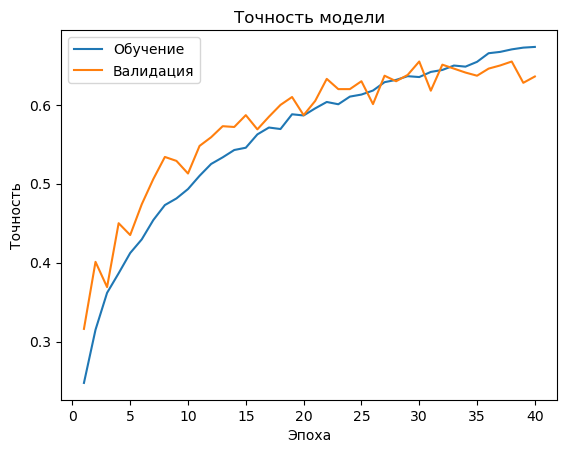

In [12]:
plt.title('Точность модели')
plt.plot(np.arange(1, len(results_baseline['mean_train_accs'])+1, dtype=np.int16), results_baseline['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, len(results_baseline['mean_train_accs'])+1, dtype=np.int16), results_baseline['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

In [13]:
print('Точность:', results_baseline['best_val_acc'])

Точность: 0.655


Видим, что точность значительно просела, когда мы увеличили число классов, придётся сделать модель поглубже, попробуем вариант Mid из прошлой работы

In [22]:
class MidLayer(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = nn.Sequential(
            BasicResBlock(in_channels, out_channels, stride=2, activation=nn.ELU()),
            BasicResBlock(out_channels, out_channels, activation=nn.ELU())
        )
    def forward(self, x):
        return self.layer(x)
    
class MidResNet(nn.Module):
    def __init__(self, class_num, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = MidLayer(3, 64) #64, 32, 32
        self.layer2 = MidLayer(64, 128) #128, 16, 16
        self.layer3 = MidLayer(128, 256) #256, 8, 8
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=class_num)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [24]:
summary(MidResNet(CLASS_NUM))

Layer (type:depth-idx)                   Param #
├─MidLayer: 1-1                          --
|    └─Sequential: 2-1                   --
|    |    └─BasicResBlock: 3-1           39,360
|    |    └─BasicResBlock: 3-2           74,112
├─MidLayer: 1-2                          --
|    └─Sequential: 2-2                   --
|    |    └─BasicResBlock: 3-3           230,528
|    |    └─BasicResBlock: 3-4           295,680
├─MidLayer: 1-3                          --
|    └─Sequential: 2-3                   --
|    |    └─BasicResBlock: 3-5           919,808
|    |    └─BasicResBlock: 3-6           1,181,184
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 2,745,812
Trainable params: 2,745,812
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─MidLayer: 1-1                          --
|    └─Sequential: 2-1                   --
|    |    └─BasicResBlock: 3-1           39,360
|    |    └─BasicResBlock: 3-2           74,112
├─MidLayer: 1-2                          --
|    └─Sequential: 2-2                   --
|    |    └─BasicResBlock: 3-3           230,528
|    |    └─BasicResBlock: 3-4           295,680
├─MidLayer: 1-3                          --
|    └─Sequential: 2-3                   --
|    |    └─BasicResBlock: 3-5           919,808
|    |    └─BasicResBlock: 3-6           1,181,184
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 2,745,812
Trainable params: 2,745,812
Non-trainable params: 0

In [25]:
def make_mid():
    return MidResNet(CLASS_NUM).to(device)

In [26]:
results_mid = train_multiple_runs(
    runs=1,
    model_constructor=make_mid,
    optimizer_constructor=init_AdamW,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=40,
    save_path= "./models/hw3/mid_best.pt"
)


===== Run 1/1 =====


Validating: 100%|██████████| 63/63 [00:01<00:00, 45.72it/s]


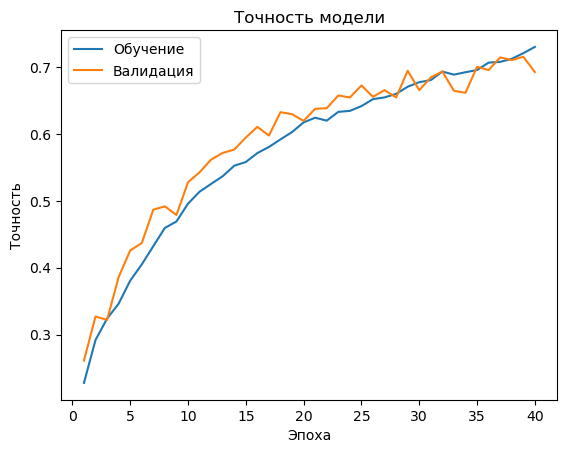

In [27]:
plt.title('Точность модели')
plt.plot(np.arange(1, len(results_mid['mean_train_accs'])+1, dtype=np.int16), results_mid['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, len(results_mid['mean_train_accs'])+1, dtype=np.int16), results_mid['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

In [30]:
class DeepLayer(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = nn.Sequential(
            BasicResBlock(in_channels, out_channels, stride=2, activation=nn.ELU()),
            BasicResBlock(out_channels, out_channels, activation=nn.ELU()),
            BasicResBlock(out_channels, out_channels, activation=nn.ELU())
        )
    def forward(self, x):
        return self.layer(x)
    
class DeepResNet(nn.Module):
    def __init__(self, class_num, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = DeepLayer(3, 64) #64, 64, 64
        self.layer2 = DeepLayer(64, 128) #128, 32, 32
        self.layer3 = DeepLayer(128, 256) #256, 16, 16
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=class_num)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [29]:
summary(DeepResNet(CLASS_NUM))

Layer (type:depth-idx)                   Param #
├─DeepLayer: 1-1                         --
|    └─Sequential: 2-1                   --
|    |    └─BasicResBlock: 3-1           39,360
|    |    └─BasicResBlock: 3-2           74,112
|    |    └─BasicResBlock: 3-3           74,112
├─DeepLayer: 1-2                         --
|    └─Sequential: 2-2                   --
|    |    └─BasicResBlock: 3-4           230,528
|    |    └─BasicResBlock: 3-5           295,680
|    |    └─BasicResBlock: 3-6           295,680
├─DeepLayer: 1-3                         --
|    └─Sequential: 2-3                   --
|    |    └─BasicResBlock: 3-7           919,808
|    |    └─BasicResBlock: 3-8           1,181,184
|    |    └─BasicResBlock: 3-9           1,181,184
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 4,296,788
Trainable params: 4,296,788
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─DeepLayer: 1-1                         --
|    └─Sequential: 2-1                   --
|    |    └─BasicResBlock: 3-1           39,360
|    |    └─BasicResBlock: 3-2           74,112
|    |    └─BasicResBlock: 3-3           74,112
├─DeepLayer: 1-2                         --
|    └─Sequential: 2-2                   --
|    |    └─BasicResBlock: 3-4           230,528
|    |    └─BasicResBlock: 3-5           295,680
|    |    └─BasicResBlock: 3-6           295,680
├─DeepLayer: 1-3                         --
|    └─Sequential: 2-3                   --
|    |    └─BasicResBlock: 3-7           919,808
|    |    └─BasicResBlock: 3-8           1,181,184
|    |    └─BasicResBlock: 3-9           1,181,184
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 4,296,788
Trainable params: 4,296,788
Non-trainable params: 0

In [31]:
def make_deep():
    return DeepResNet(CLASS_NUM).to(device)

In [32]:
results_deep = train_multiple_runs(
    runs=1,
    model_constructor=make_deep,
    optimizer_constructor=init_AdamW,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=40,
    save_path= "./models/hw3/deep_best.pt"
)


===== Run 1/1 =====


Validating: 100%|██████████| 63/63 [00:01<00:00, 33.96it/s]


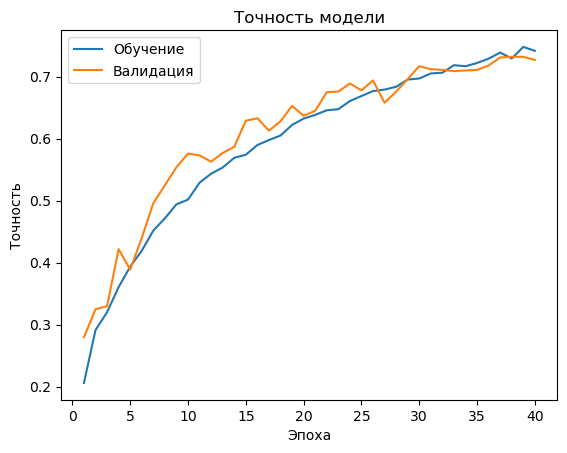

In [33]:
plt.title('Точность модели')
plt.plot(np.arange(1, len(results_deep['mean_train_accs'])+1, dtype=np.int16), results_deep['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, len(results_deep['mean_train_accs'])+1, dtype=np.int16), results_deep['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()